#Традиционный анализ фондового рынка
Сначала мы попробовали выгрузить информацию с сайта мос. биржи, но как оказалась они не имеют гибкого api(оно не позволяет скачать информацию сразу об всех акциях и их изменениях за определенный период). Эту часть кода мы оставили просто для того, чтобы поработать хоть как-то с их api и выбрать только компании 1-2 эшелона.



In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import io
meta_url = "https://iss.moex.com/iss/engines/stock/markets/shares/securities.csv"
resp = requests.get(meta_url)
raw = resp.content.decode('cp1251')
lines = raw.splitlines()
start = 2 # skip line with filename
securities_lines = []
for l in lines[start:]:
  if l.strip() == '':
      break
  securities_lines.append(l)
# create pd table
meta = pd.read_csv(io.StringIO('\n'.join(securities_lines)), delimiter=';')
#filtrate them
currency_col = 'FACEUNIT' if 'FACEUNIT' in meta.columns else 'CURRENCYID'
meta = meta[meta['LISTLEVEL'].isin([1,2])]
liquid_tickers = meta['SECID'].unique().tolist()
print(len(liquid_tickers))

187



## Работа с файлами.
К сожалению, для нахождения кыоэффициентов Грэма, а ровно как и  справедливую цену данных с мос. биржи не достаточно. Агрегаторов данных с открытым api мы не нашли, поэтому пришлось прибегнуть к парсингу таблиц с https://smart-lab.ru/. К сожалению, colab не имеет возможности работать с selenuim (парсинг проходил через него), поэтому таблички загружаем вручную.

In [3]:
file_names = [
    "dividends.csv", "pe_ratio.csv", "ps_ratio.csv", "pb_ratio.csv", "debt.csv",
    "ebitda_margin.csv", "revenue.csv", "market_cap.csv", "net_income.csv",
    "eps.csv", "dividend_payout.csv", "div_payout_ratio.csv", "book_value.csv"
]

Данных взяли с запасом, может кто-то и понадобиться. Использовали не все. В данном отрывке кода используем фильтр, чтобы отобрать только ликвидные тикеры. Исключение col_11 является просто багом, ввиду не самого лучшего парсинга таблиц.

In [4]:
data = {}
for name in file_names:
    df = pd.read_csv(name).drop(columns=['col_11'], errors='ignore')
    df = df[df['ТИКЕР'].isin(liquid_tickers)].set_index('ТИКЕР')
    data[name.replace('.csv', '')] = df

Просто избавление от ненужных символов и приведение данных в анализируемый вид

In [5]:
def clean_numeric_columns(df, years=range(2022, 2026)):
    for col in map(str, years):
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(' ', '', regex=False)
                .str.replace(',', '.', regex=False)
                .str.replace('%', '', regex=False)
                .replace({'–': np.nan, '-': np.nan})
                .astype(float)
            )
    return df

for name, df in data.items():
    data[name] = clean_numeric_columns(df)


Здесь возникла одна проблемка. Таблицы pe, ps, pb - почти пусты(таков уж агрегатор). Поэтому, чтобы провести дальнейший рассчет используем те данные, у которых мало пустых.

P/E = рыночная капитализация компании / чистая прибыль компании - показывает сколько инвестр готов заплатить за каждый рубль прибыли

P/S = рыночная капитализация / выручка

P/B = рыночная капитализация / балансовая стоимость компании​


In [35]:
years = [str(y) for y in range(2022, 2025)]
eps = data['eps'][years]
net_income = data['net_income'][years]
revenue = data['revenue'][years]
market_cap = data['market_cap'][years]
dividends = data['dividends'][years]
debt = data['debt'][years]
book_value = data['book_value'][years]

pe_ratio = market_cap / net_income.replace(0, np.nan)
ps_ratio = market_cap / revenue.replace(0, np.nan)
div_yield = dividends / market_cap.replace(0, np.nan)
debt_to_cap = debt / market_cap.replace(0, np.nan)
pb_ratio = market_cap / book_value.replace(0, np.nan)
count = net_income / eps.replace(0, np.nan)
price = market_cap / count
data['pe_ratio'] = pe_ratio
data['pb_ratio'] = pb_ratio
data['ps_ratio'] = ps_ratio
data['div_yield'] = div_yield
data['debt_to_cap'] = debt_to_cap
data['count'] = count
data['price'] = price

Высчитываем коэфициент Грема честную стоимость и премию Грэма(штуку которая показывает во сколько раз настоящая цена акции отличается от той, которая являетсяс честной по Грэму)

справед

In [36]:
graham_fair_price = np.sqrt(22.5 * eps * book_value)
graham_premium = price / graham_fair_price

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


In [37]:
def calculate_cagr(df, start_year, end_year):
    return ((df[str(end_year)] / df[str(start_year)]) ** (1 / (end_year - start_year))) - 1

In [38]:
cagr_income = calculate_cagr(net_income, 2022, 2024)
cagr_revenue = calculate_cagr(revenue, 2022, 2024)

In [47]:
filtered_graham_premium = graham_premium[years[-1]].where(
    (graham_premium[years[-1]] >= 0.2) & (graham_premium[years[-1]] < 1))
filtred_cagr_income = cagr_income.where(cagr_income > 0)
filtred_cagr_revenue = cagr_revenue.where(cagr_revenue > 0)
score = (
    filtred_cagr_revenue.rank(pct=True) +
    filtred_cagr_income.rank(pct=True) +
    filtered_graham_premium.rank(pct=True) +
    div_yield[years[-1]].rank(pct=True) -
    debt_to_cap[years[-1]].rank(pct=True)
)

summary = pd.DataFrame({
    'score': score,
    'graham_premium': filtered_graham_premium,
    'cagr_revenue': filtred_cagr_revenue,
    'cagr_income': filtred_cagr_income,
})
summary= summary.dropna(thresh=4)


,score,graham_premium,cagr_revenue,cagr_income
ТИКЕР,,,,
EUTR,2.63275,0.80674,0.69382,0.77442
LSRG,1.91927,0.90409,0.30853,0.46093
SELG,1.91324,0.87556,0.30726,0.15822
OZPH,1.75304,0.99360,0.16076,0.12384
CHMF,1.56401,0.94864,0.10289,0.17477
TATN,1.37551,0.36014,0.19271,0.03654


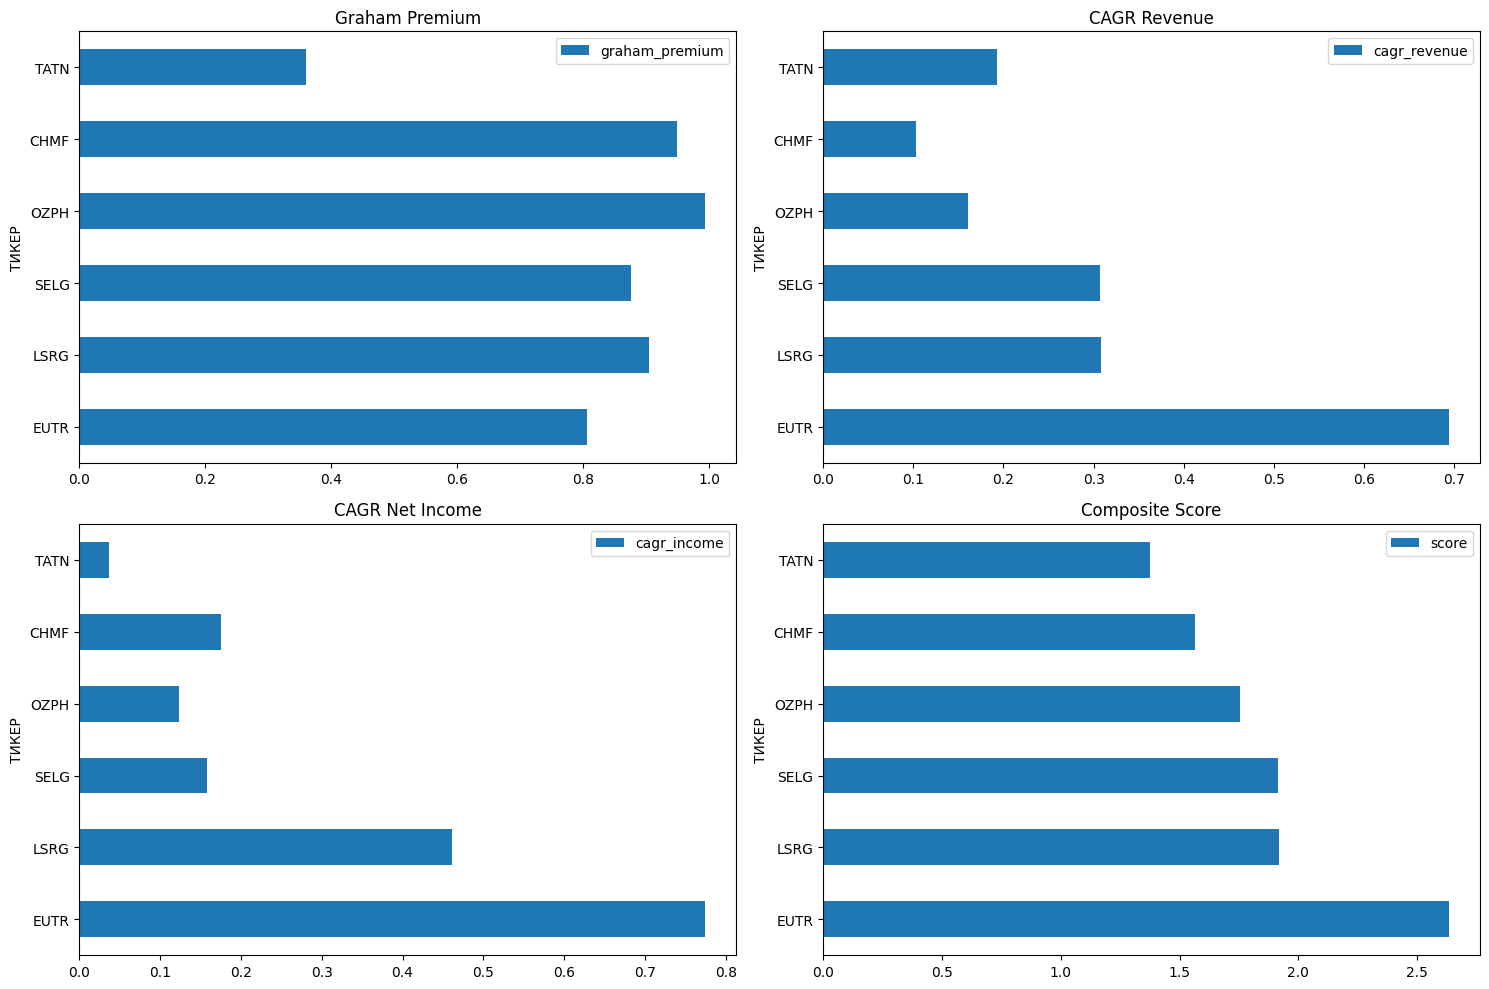

In [48]:
top = summary.sort_values(by='score', ascending=False).head(10)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
top[['graham_premium']].plot(kind='barh', ax=axs[0, 0], title='Graham Premium')
top[['cagr_revenue']].plot(kind='barh', ax=axs[0, 1], title='CAGR Revenue')
top[['cagr_income']].plot(kind='barh', ax=axs[1, 0], title='CAGR Net Income')
top[['score']].plot(kind='barh', ax=axs[1, 1], title='Composite Score')
plt.tight_layout()

top.round(5)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

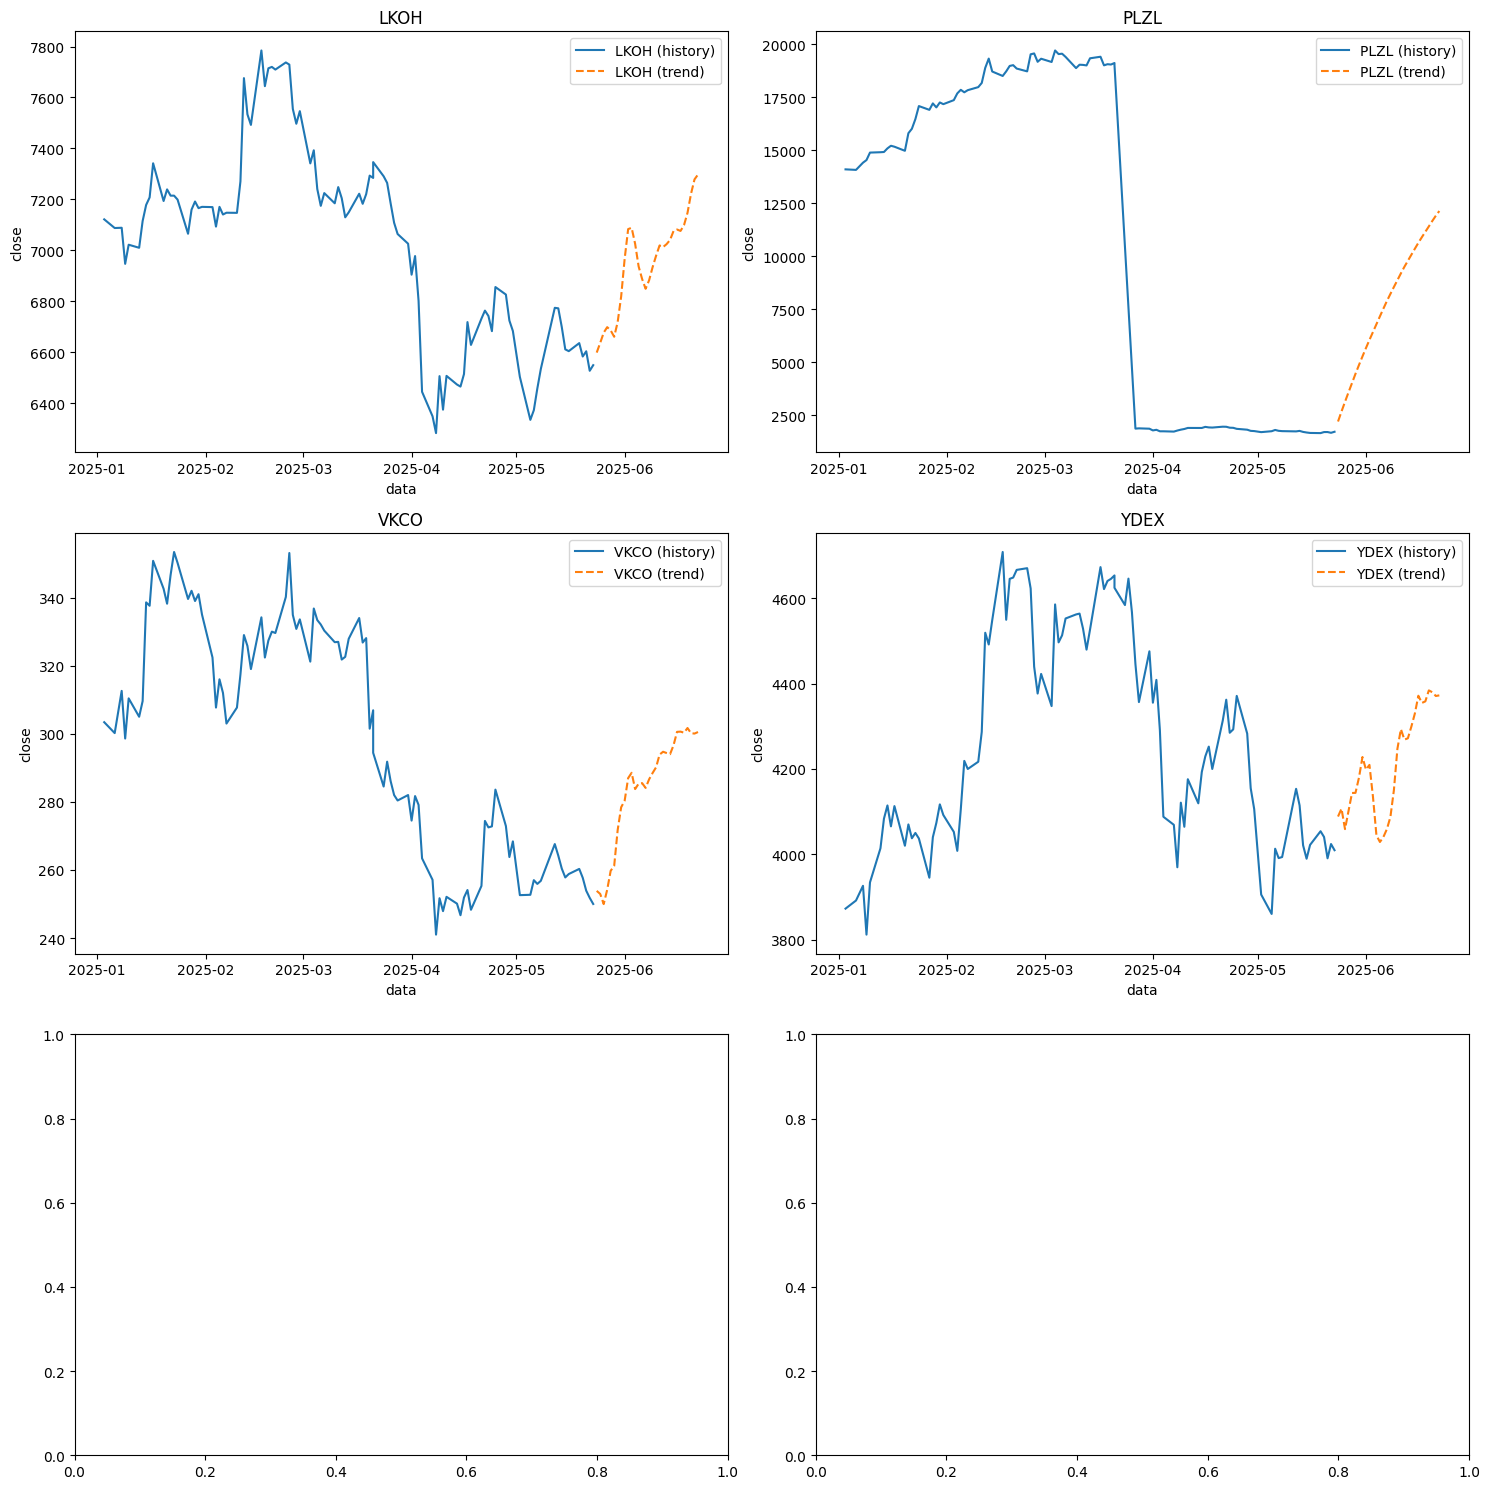

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('merged.csv')
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
df = df[['TRADEDATE', 'SECID', 'CLOSE']]
top_companies = top.index
df_top = df[df['SECID'].isin(top_companies)]
tickers = df_top['SECID'].unique()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()
for i, ticker in enumerate(tickers[:6]):
    ticker_data = df_top[df_top['SECID'] == ticker]

    ticker_data.set_index('TRADEDATE', inplace=True)

    ts = ticker_data['CLOSE']

    model = ARIMA(ts, order=(30, 0, 0))  # ARIMA((за какой до), d, учет ошибок)

    model_fit = model.fit()

    forecast = model_fit.forecast(steps=30)

    future_dates = pd.date_range(ts.index[-1], periods=31, freq='D')[1:]

    axs[i].plot(ts.index, ts, label=f'{ticker} (history)', linestyle='-')
    axs[i].plot(future_dates, forecast, label=f'{ticker} (trend)', linestyle='--')
    axs[i].set_title(f'{ticker}')
    axs[i].set_xlabel('data')
    axs[i].set_ylabel('close')
    axs[i].legend()

plt.tight_layout()
plt.show()
